In [49]:
# Librairies
import os
import sys
code_path = os.path.split(os.getcwd())[0]
sys.path.append(code_path)
import numpy as np
from scipy.sparse import load_npz
import seaborn as sns
import pandas as pd
from setting import *
from loader import *
from graphs import *
from utils import *
from plots_and_stats import *
from clustering import *
from XAI_method import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [50]:
# Arguments
name = "pancan"
model_name = 'MLP'
exp = 1
XAI_method = "Integrated_Gradients" # "Expected_Gradients"
set_name = 'train'

In [51]:
# Path
save_path = get_save_path(name, code_path)
save_path = os.path.join(save_path, model_name, f"exp_{exp}", XAI_method)
data_path = get_data_path(name)
create_new_folder(os.path.join(save_path, "figures", set_name))

In [52]:
# Load explanations
attr, label_pred, label, class_name, feat_name, baseline, baseline_pred = load_attributions(XAI_method, save_path, set_name=set_name)


In [53]:
# Load data
train_loader, test_loader, n_class, n_feat, class_name, feat_name, transform, n_sample = load_dataloader(data_path, name, device)
if set_name == 'train':
    loader = train_loader
elif set_name == 'test':
    loader = test_loader


934 weakly expressed genes are removed of the dataset.


In [ ]:
# Studied classes
base_class, studied_class = get_XAI_hyperparameters(name, n_class)

In [60]:
# Dataset
n_sample = len(attr)
n_feat = attr.shape[1]
X = np.zeros((n_sample, n_feat))
y = np.ones(n_sample, dtype='int')

torch.manual_seed(1)
count = 0
for i, (x, target) in enumerate(loader):
    # print(i, end='\r')
    x = x[sum(target == c for c in studied_class).bool()]
    target = target[sum(target == c for c in studied_class).bool()]
    batch_size = x.shape[0]
    x = x.to(device)
    if transform:
        x = transform(x)
    X[count:count + batch_size, :] = x.detach().cpu().numpy()
    y[count:count + batch_size] = target.detach().cpu()
    count = count + batch_size

assert (y == label).all()

# Visualise attributions

In [62]:
# Only correctly classified examples are considered
indices = np.argwhere(label_pred == label).reshape(-1)
attr = attr[indices]
label = label[indices]
X = X[indices]

In [63]:
# Attributions 
normalize = True
if normalize:
    attr = transform_data(attr, transform='divide_by_norm')

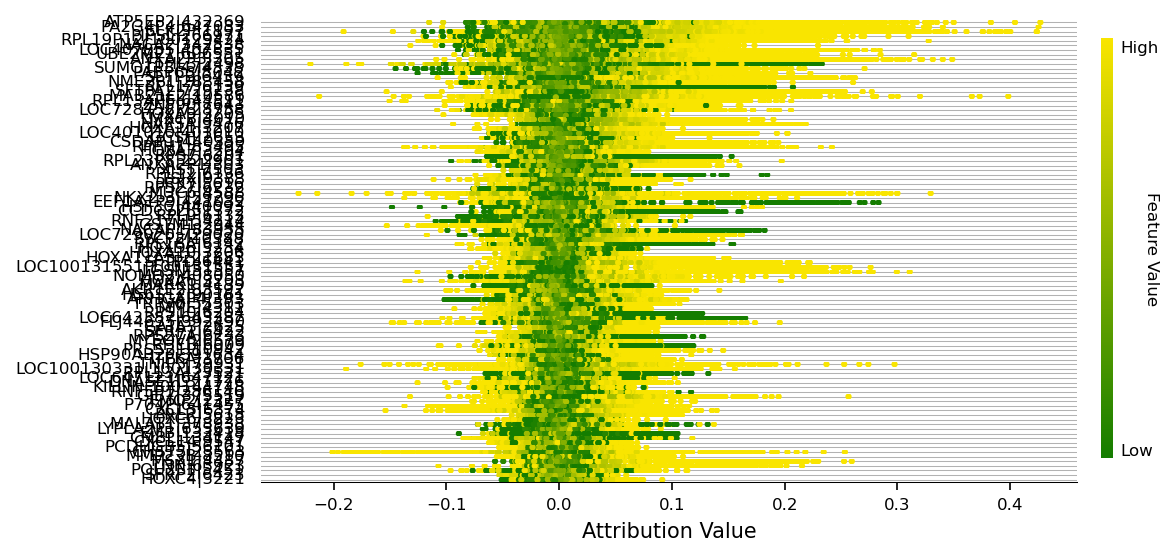

In [64]:
# Visualisation with a function extracted from another github
code_path = os.path.join(os.path.split(os.path.split(os.getcwd())[0])[0], "path_explain_master")
sys.path.append(code_path)
from path_explain import summary_plot, scatter_plot

summary_plot(attributions=attr,
             feature_values=X,
             feature_names=feat_name,
             plot_top_k=100)

Class 1


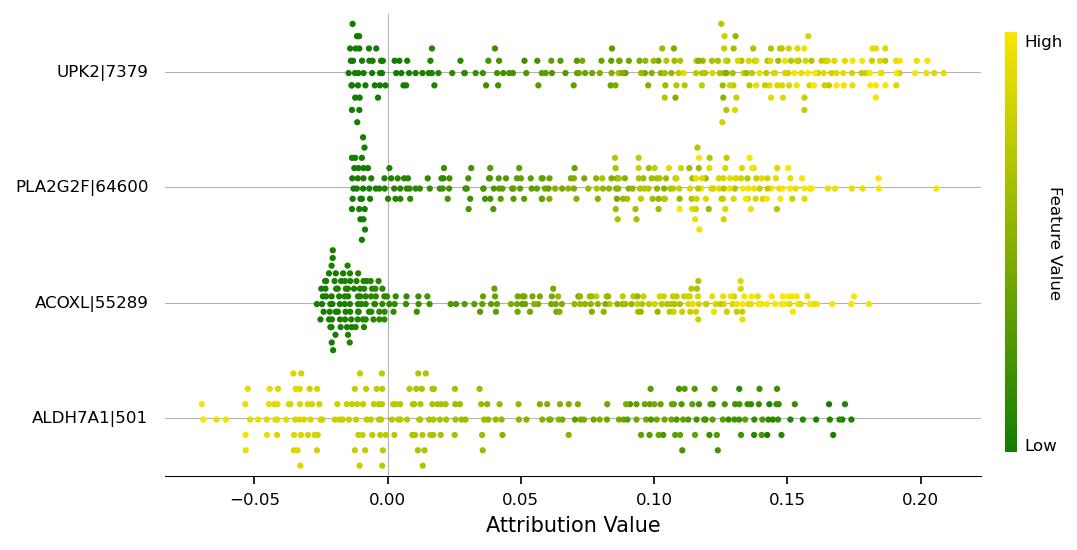

In [65]:
_class = 1
print(f"Class {_class}")
summary_plot(attributions=attr[y == _class],
             feature_values=X[y == _class],
             feature_names=feat_name,
             plot_top_k=4)

# Visualise interaction

In [66]:
# interactions - matrix of size (n_sample, n_feat, n_feat)

if XAI_method == "Expected_Gradients":
    interactions, _, label2, class_name, feat_name, baseline, baseline_pred = load_attributions(XAI_method + "_interactions", save_path, set_name=set_name)
    # Only correctly classified examples are considered  
    interactions = interactions[indices, :]
    label2 = label2[indices]
    assert (label2 == label).all()
    

In [67]:
# Visualisation with a function extracted from another github
# 3 plots. Samples colored by color_by.
# 1 - Attribution of feature_index = f (value of feature_index)
# 2 - Interaction between feature_index and color_by = f (value of feature_index)
# 3 - Main effect of feature_index = f (value of feature_index)
if XAI_method == "Expected_Gradients":
    scatter_plot(attributions=attr,
                 feature_values=X,
                 feature_index=0,
                 interactions=interactions,
                 color_by=2,
                 feature_names=feat_name,
                 scale_y_ind=True)  # Set to True to scale the y axes of each plot independently
    plt.show()

In [68]:
if XAI_method == "Expected_Gradients":
    _class = 1
    print(f"Class {_class}")
    scatter_plot(attributions=attr[y == _class],
                 feature_values=X[y == _class],
                 feature_index=0,
                 interactions=interactions[y == _class],
                 color_by=2,
                 feature_names=feat_name,
                 scale_y_ind=True)
    plt.show()

In [69]:
# Show the interaction matrix for a sample
if XAI_method == "Expected_Gradients":
    sample = 0
    plt.matshow(interactions[sample])
    plt.colorbar()
    plt.show()
    plt.matshow(interactions[sample][:100, :][:, :100])
    plt.colorbar()
    plt.show()